In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt


In [2]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()



In [3]:
standardizer = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [4]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
noise_dim = 32
BATHC_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 200
DEBUG = False

In [6]:
def block(in_features, out_features, batch_norm=True):
                layers = [nn.Linear(in_features=in_features, out_features=out_features)]
                if batch_norm:
                    layers.append(nn.BatchNorm1d(out_features, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

In [7]:
class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                *block(noise_dim, 128, batch_norm=False),
                *block(128, 256),
                *block(256, 512),
                *block(512, 28 * 28),
                nn.Tanh()
            )
            if DEBUG:
                self.layer1 = nn.Linear(noise_dim, 128)
                self.batch_norm1 = nn.BatchNorm1d(128)
                self.leaky_relu = nn.LeakyReLU(0.9)

                self.layer2 = nn.Linear(128, 256)
                self.batch_norm2 = nn.BatchNorm1d(256)

                self.layer3 = nn.Linear(256, 512)
                self.batch_norm3 =nn.BatchNorm1d(512)
                
                self.layer4 = nn.Linear(512, 28 * 28)
                self.batch_norm4 = nn.BatchNorm1d(28 * 28)
                self.tanh = nn.Tanh()
        
        def forward(self, x):
            batch_size = x.shape[0]
            if not DEBUG:
                x = self.model(x)
            else:
                x = self.layer1(x)
                x = self.batch_norm1(x)
                x = self.leaky_relu(x)
                x = self.layer2(x)
                x = self.batch_norm2(x)
                x = self.leaky_relu(x)
                x = self.layer3(x)
                x = self.batch_norm3(x)
                x = self.leaky_relu(x)
                x = self.layer4(x)
                x = self.batch_norm4(x)
                x = self.leaky_relu(x)
            x = x.view((batch_size, 1, 28, 28))
            return x



In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
                *block(28 * 28, 128, batch_norm=False),
                *block(128, 256, batch_norm=False),
                *block(256, 1, batch_norm=False),
                nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view((batch_size, -1))
        x = self.model(x)
        return x



In [9]:
def get_z(batch_size=BATHC_SIZE):
    return cuda.FloatTensor(torch.randn(batch_size, noise_dim, device=device))

In [10]:
def train(G, D, train_loader, G_optim, D_optim):
    G.train()
    D.train()
    criterion = nn.BCELoss()
    for epoch in range(EPOCHS):
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            
            D_optim.zero_grad()
            p_real = D(imgs)
            p_fake = D(G(get_z(batch_size=imgs.shape[0])))

            loss_d_real = criterion(p_real, torch.ones_like(p_real).to(device))  #-1.0 * torch.log(p_real)
            loss_d_fake = criterion(p_fake, torch.zeros_like(p_fake).to(device))  #-1.0 * torch.log(1. - p_fake)

            loss_d = (loss_d_real + loss_d_fake)  #.mean()

            loss_d.backward()
            D_optim.step()

            G_optim.zero_grad()

            #p_fake = -1.0 * torch.log(G(get_z(batch_size=imgs.shape[0])))

            loss_g =  criterion(D(G(get_z(batch_size=imgs.shape[0]))), torch.ones_like(p_fake).to(device)) #-1.0 * torch.log(p_fake).mean()

            loss_g.backward()

            G_optim.step()
        
        if epoch % 10 == 0:
            print(f'[{epoch}/{EPOCHS}] Loss_G : {loss_g:.5f}, Loss_D : {loss_d:.5f}')
            imshow_grid(G(get_z(batch_size=16)))
            
    torch.save(G, './model/generator.pth')
    torch.save(D, './model/discriminator.pth')

In [11]:
train_data = datasets.MNIST(root='./mnist/', train=True, download=True, transform=standardizer)
test_data = datasets.MNIST(root='./mnist/', train=False, download=True, transform=standardizer)
total_train = torch.utils.data.ConcatDataset([train_data, test_data])

train_dataloader = torch.utils.data.DataLoader(dataset=total_train, batch_size=BATHC_SIZE, shuffle=True)

In [12]:
def init_params(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)



In [13]:
gen = Generator().to(device)
disc = Discriminator().to(device)
init_params(gen)
init_params((disc))
optim_G = optim.Adam(lr=LEARNING_RATE, params=gen.parameters())
optim_D = optim.Adam(lr=LEARNING_RATE, params=disc.parameters())

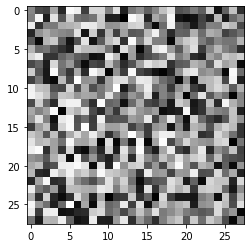

torch.Size([10, 28, 28])

In [14]:
z = get_z(batch_size=10)
img_fake = gen(z).view((-1, 28, 28))
imshow(img_fake[0].cpu().detach())
img_fake.shape

[0/200] Loss_G : 5.62899, Loss_D : 0.00398


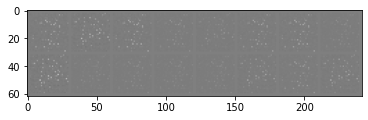

[10/200] Loss_G : 11.21344, Loss_D : 0.00002


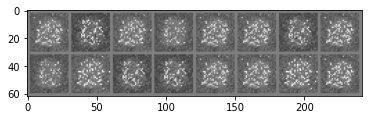

[20/200] Loss_G : 27.17882, Loss_D : 0.24487


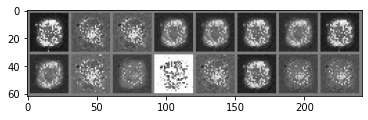

[30/200] Loss_G : 5.99438, Loss_D : 0.06439


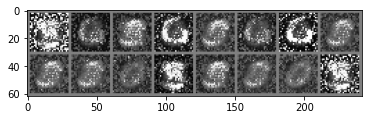

[40/200] Loss_G : 3.77875, Loss_D : 0.08267


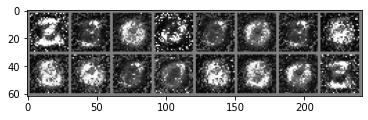

[50/200] Loss_G : 100.00001, Loss_D : 94.89572


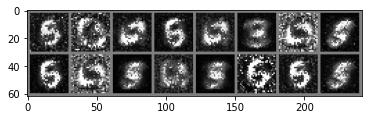

[60/200] Loss_G : 100.00001, Loss_D : 95.76620


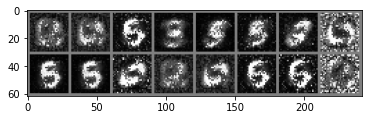

[70/200] Loss_G : 100.00001, Loss_D : 96.63218


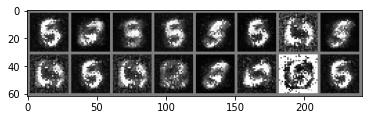

[80/200] Loss_G : 100.00001, Loss_D : 96.84115


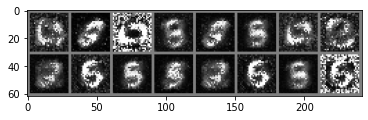

[90/200] Loss_G : 100.00001, Loss_D : 96.06613


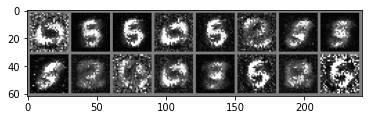

[100/200] Loss_G : 100.00001, Loss_D : 95.91457


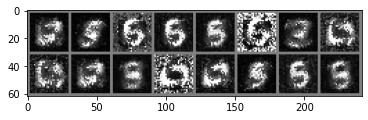

[110/200] Loss_G : 100.00001, Loss_D : 97.22941


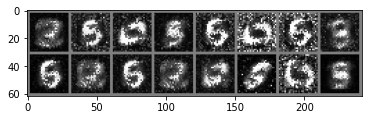

[120/200] Loss_G : 100.00001, Loss_D : 100.00001


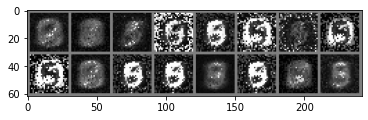

[130/200] Loss_G : 100.00001, Loss_D : 100.00001


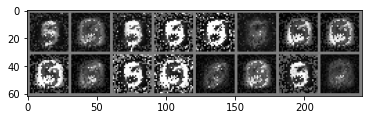

[140/200] Loss_G : 100.00001, Loss_D : 100.00001


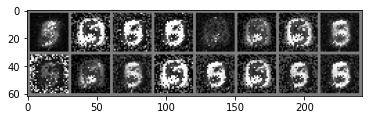

[150/200] Loss_G : 100.00001, Loss_D : 100.00001


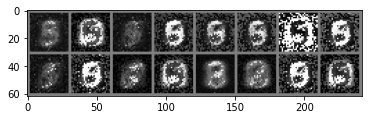

[160/200] Loss_G : 100.00001, Loss_D : 100.00001


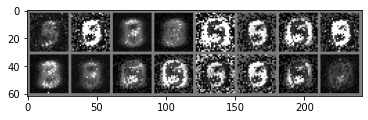

[170/200] Loss_G : 100.00001, Loss_D : 100.00001


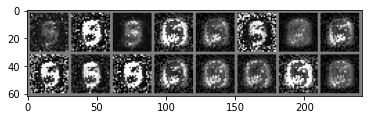

[180/200] Loss_G : 100.00001, Loss_D : 100.00001


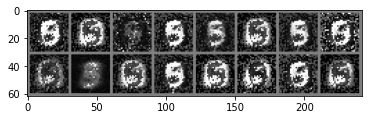

[190/200] Loss_G : 100.00001, Loss_D : 100.00001


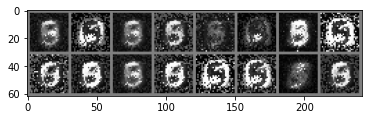

In [15]:
train(gen, disc, train_dataloader, optim_G, optim_D)

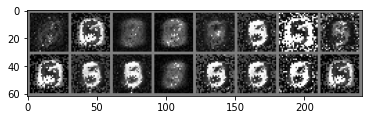

In [23]:
z = get_z(batch_size=16)
imgs = gen(z)
imshow_grid(imgs.cpu().detach())